In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import kagglehub

In [2]:
# Augmentation Sequence
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotate images within [-10, 10] degrees
    iaa.AddToBrightness((-2, 2)),  # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.00001 * 255)) # Add Gaussian noise
])

In [3]:
def get_data_with_augmentation(data_dir):
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i, label in enumerate(dir_list):
        print("Obtaining and augmenting images of", label, "...")
        for image in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, image)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (32, 32))

            # Append the original image
            images.append(img)
            labels.append(i)

            # Apply augmentations
            img_augmented = augmentation(images=[img] * 2)  
            images.extend(img_augmented)
            labels.extend([i] * len(img_augmented))

    return np.array(images), np.array(labels)


In [4]:
# Load and augment data
path = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")
train_images = os.path.join(path, 'Train_Alphabet')
X, y = get_data_with_augmentation(train_images)

# Normalize data
X_normalized = X.astype('float32') / 255.0

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Encode labels
labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'Blank', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 
    'Y', 'P', 'W'
]
y_train_encoded = to_categorical(y_train, num_classes=len(labels))
y_test_encoded = to_categorical(y_test, num_classes=len(labels))

Obtaining and augmenting images of R ...
Obtaining and augmenting images of U ...
Obtaining and augmenting images of I ...
Obtaining and augmenting images of N ...
Obtaining and augmenting images of G ...
Obtaining and augmenting images of Z ...
Obtaining and augmenting images of T ...
Obtaining and augmenting images of S ...
Obtaining and augmenting images of A ...
Obtaining and augmenting images of F ...
Obtaining and augmenting images of O ...
Obtaining and augmenting images of H ...
Obtaining and augmenting images of Blank ...
Obtaining and augmenting images of M ...
Obtaining and augmenting images of J ...
Obtaining and augmenting images of C ...
Obtaining and augmenting images of D ...
Obtaining and augmenting images of V ...
Obtaining and augmenting images of Q ...
Obtaining and augmenting images of X ...
Obtaining and augmenting images of E ...
Obtaining and augmenting images of B ...
Obtaining and augmenting images of K ...
Obtaining and augmenting images of L ...
Obtaining an

In [5]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut to match dimensions if necessary
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [6]:
# Building the ResNet model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(32, (3, 3), padding='same', strides=1, kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual blocks
    x = resnet_block(x, 64, stride=1)
    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 128, stride=1)
    x = resnet_block(x, 128, stride=2)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


Epoch 1/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.3081 - loss: 2.4428 - val_accuracy: 0.8603 - val_loss: 0.4745
Epoch 2/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.9112 - loss: 0.2997 - val_accuracy: 0.9363 - val_loss: 0.2080
Epoch 3/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - accuracy: 0.9635 - loss: 0.1263 - val_accuracy: 0.9455 - val_loss: 0.1698
Epoch 4/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.9794 - loss: 0.0755 - val_accuracy: 0.9658 - val_loss: 0.1040
Epoch 5/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.9837 - loss: 0.0541 - val_accuracy: 0.9595 - val_loss: 0.1301
Epoch 6/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.9884 - loss: 0.0396 - val_accuracy: 0.9493 - val_loss: 0.1842
456/456 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9655 - loss: 0.1040
Test Loss: 0.1064, Test Accuracy: 0.9645


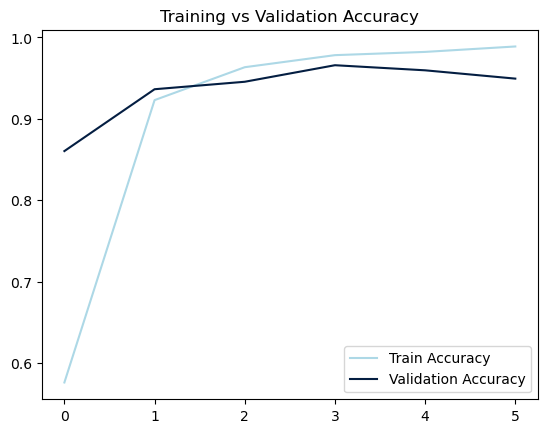

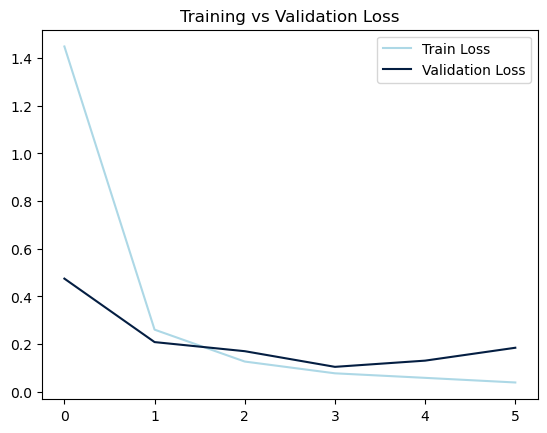

In [ ]:
# Model parameters
input_shape = (32, 32, 3)
num_classes = len(labels)
batch = 96
epochs = 10
learning_rate = 0.001

# Build and compile the ResNet model
model = build_resnet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train_encoded,
    batch_size=batch,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#ADD8E6')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#041E42')
plt.legend()
plt.title('Training vs Validation Accuracy')
# plt.savefig('train_vs_val_accuracy.png')
plt.show()

plt.plot(history.history['loss'], label='Train Loss', color='#ADD8E6')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#041E42')
plt.legend()
plt.title('Training vs Validation Loss')
# plt.savefig('train_vs_val_loss.png') 

plt.show()

# Save the model
model.save('./models/resnet.h5')
